In [21]:
# Data Analysis modules
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6
plt.figure(figsize=(12,8))
plt.style.use('seaborn-white')
%matplotlib inline
import seaborn; seaborn.set() 
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import pickle
import os

# ARIMA and Time Series modules
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
import plotly.express as px

<Figure size 1200x800 with 0 Axes>

In [17]:
# Methods to load and save data from/to pickles
def save_to_pickle(obj, path='default.pkl'):
    if not os.path.exists(path):
        pickle.dump(obj, open(path, 'wb'))
    
def load_from_pickle(path='default.pkl'):
    if os.path.exists(path):
      with open(path, 'rb') as f:
        model = pickle.load(f)
        print(model)
        return model
    else:
      return None

In [5]:
# Loading the series from csv files
path = 'data-2009-2017/'
df_marsa = pd.read_csv(path + 'nserie-marsa.csv', index_col= None, header=None)
df_levoflo = pd.read_csv(path + 'dserie-levoflo.csv', index_col= None, header=None)
df_staphylo = pd.read_csv(path + 'nserie-staphylo.csv', index_col= None, header=None)

In [6]:
# Date formating: We have data from 2009 to 2018
from datetime import datetime, timedelta
import dateutil.parser

months = pd.date_range("2009-01-31", "2018-01-31", freq='M')
months = pd.to_datetime(months)
df_marsa.set_index(months, drop=True, inplace=True)
df_staphylo.set_index(months, drop=True, inplace=True)
df_levoflo.set_index(months, drop=True, inplace=True)

In [7]:
# Training set: 2009-2016
# Test set: 2017
df_training, df_test = df_marsa[0][0:96], df_marsa[0][96:]

df_training = pd.DataFrame(df_training)
df_test = pd.DataFrame(df_test)

In [8]:
from scipy.optimize import brute

# Root mean squared error
def get_rmse(y, y_hat):
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

# ARIMA Modeling
def auto_arima(endog, verbose = True, 
                ranges = (slice(0,5), slice(0,2), slice(0,5), slice(0,5), slice(0,2), slice(0,5), slice(0,12))):      
    global grid
    grid = []
    resultsbrute = brute(arima_modeling, ranges=ranges, args=(endog,), 
                         full_output=True, finish=None)
    del grid[0]
    return resultsbrute

def arima_modeling(coeffs, *args):
    endog = args[0]
    order = coeffs[0:3].tolist()
    seasonal_order = coeffs[3:7].tolist()
    try:        
        mod = SARIMAX(endog, order=order, seasonal_order=seasonal_order, 
                      enforce_stationarity=False, enforce_invertibility=False)
        fit = mod.fit(disp=False)
        aic = fit.aic
        bic = fit.bic
        rmse = get_rmse(df_test[0], fit.predict(start = 96, end = df_test.index[-1]))
        rmse6 = get_rmse(df_test[0], fit.predict(start = 96, end = 102))
        rmse3 = get_rmse(df_test[0], fit.predict(start = 96, end = 99))
    except:             
        aic, bic, rmse, rmse6, rmse3, fit =  np.inf, np.inf, np.inf, np.inf, np.inf, np.inf
    global grid
    grid.append([coeffs, aic, bic, rmse, rmse6, rmse3, fit])
    return rmse

In [ ]:
df_grid = pd.DataFrame(grid)
df_grid.columns = ['Model', 'BIC', 'AIC', 'RMSE', 'RMSE6', 'RMSE3', 'ModelFit']
df_grid.sort_values('RMSE', inplace=True)
df_grid.dropna(inplace=True)
df_grid = df_grid[df_grid['BIC'] != np.Inf]
save_to_pickle(df_grid, 'dataframes/MARSA_grid.pkl')

In [ ]:
# We already have the data stored into MARSA_grid.pkl but it can be generated calling auto_arima
df_grid = load_from_pickle('dataframes/MARSA_grid.pkl')
df_grid

## MARSA Series Representation

In [22]:
px.line(df_marsa, x=df_marsa.index, y=0)

### MARSA Series Histogram

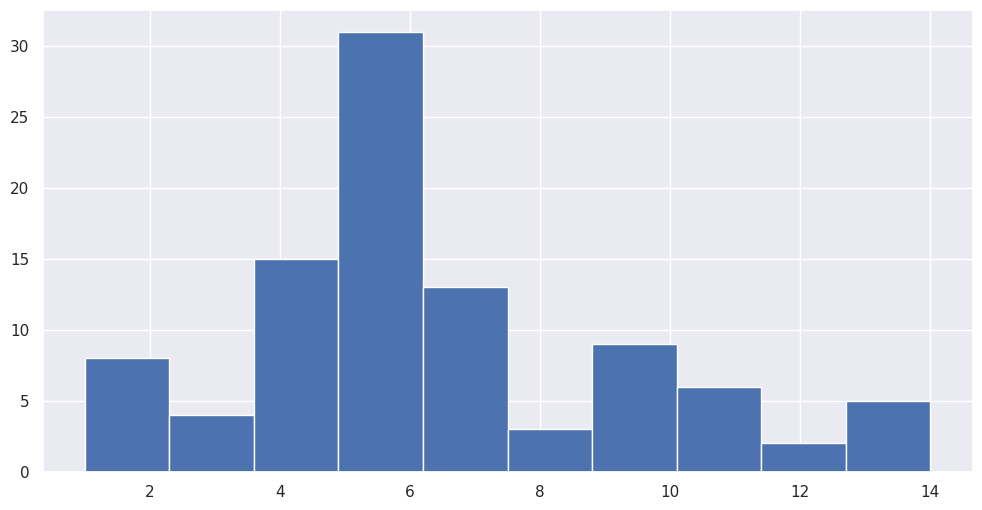

In [23]:
hist = df_training[0].hist()

### Moving Average Representation: window = 6 & 12 months

In [26]:
import plotly.graph_objects as go

rolmean = df_marsa.rolling(window=6).mean()
rolmean.set_index(df_marsa.index, inplace=True)

moving_average_marsa = go.Figure(data=go.Scatter(x=df_marsa.index, 
                        y=rolmean[0].values,
                        marker_color='indianred', text="ma_marsa"))

moving_average_marsa.show()

In [27]:
import plotly.graph_objects as go

rolmean = df_marsa.rolling(window=12).mean()
rolmean.set_index(df_marsa.index, inplace=True)

moving_average_marsa = go.Figure(data=go.Scatter(x=df_marsa.index, 
                        y=rolmean[0].values,
                        marker_color='indianred', text="ma_marsa"))

moving_average_marsa.show()

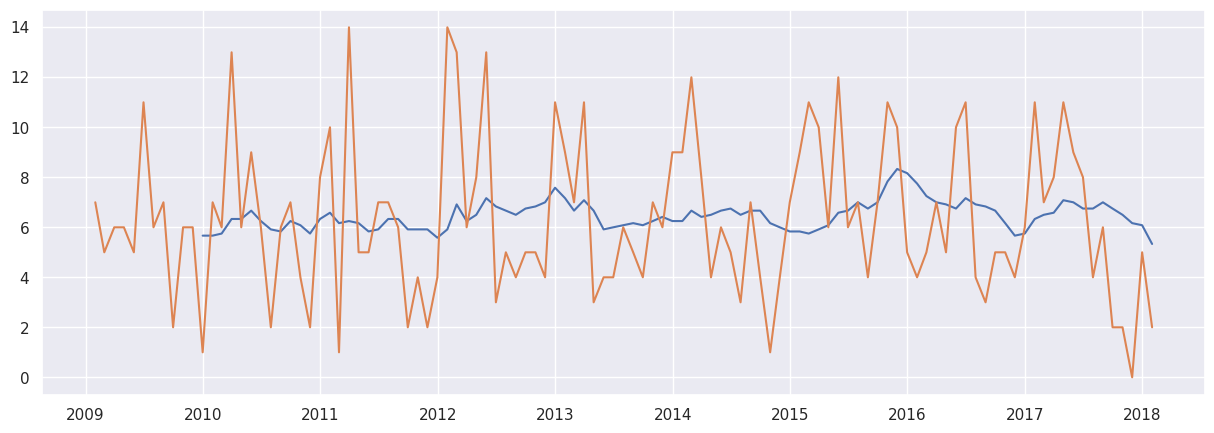

In [28]:
plt.figure(figsize=(15,5))
plt.plot(rolmean)
plt.plot(df_marsa)

### MARSA Differencing and Moving Average

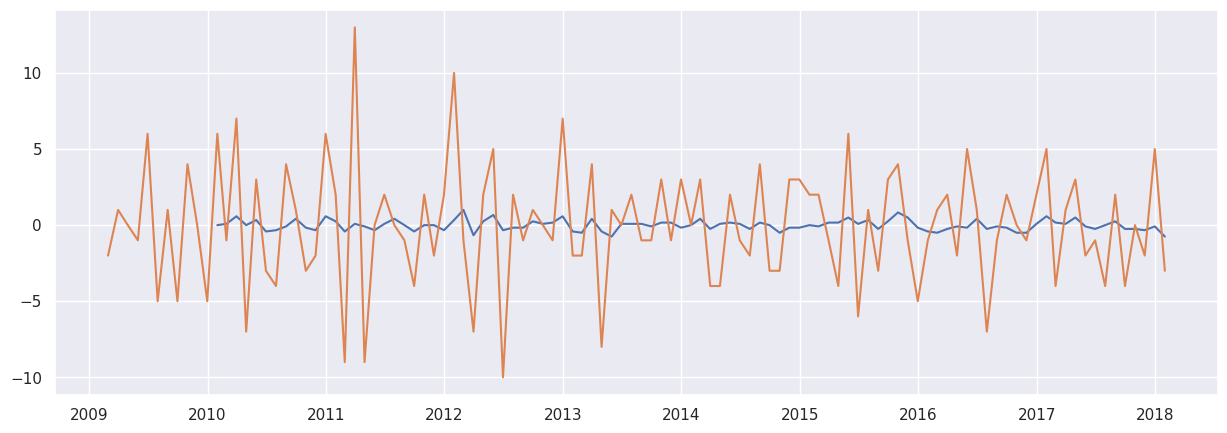

In [30]:
df_marsa_dif = df_marsa.diff()

rolmean = df_marsa_dif.rolling(window=12).mean()
rolmean.set_index(df_marsa_dif.index, inplace=True)

plt.figure(figsize=(15,5))
plt.plot(rolmean)
plt.plot(df_marsa_dif)

### Variance Representation

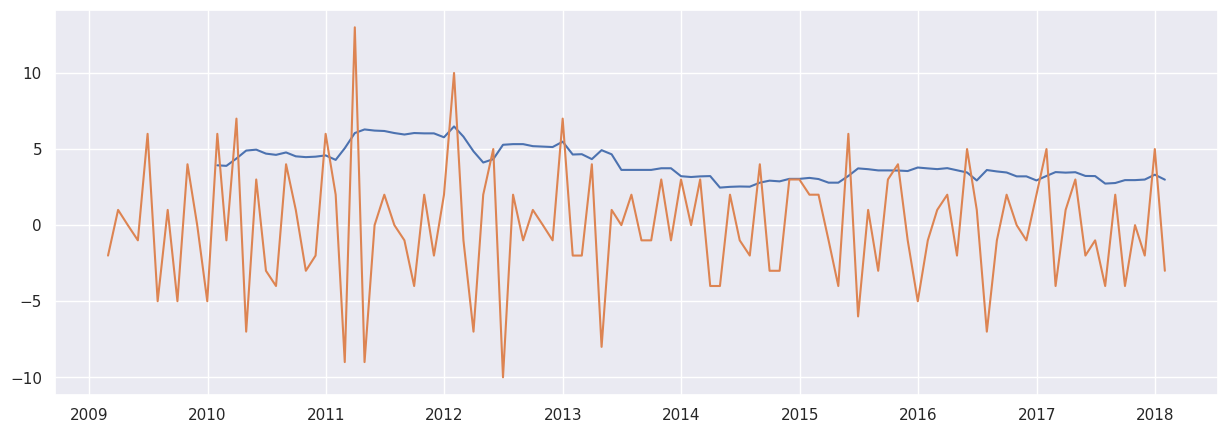

In [31]:
rolstd_dif = df_marsa_dif.rolling(window=12).std()
rolstd_dif.set_index(df_marsa_dif.index, inplace=True)

plt.figure(figsize=(15,5))
plt.plot(rolstd_dif)
plt.plot(df_marsa_dif)

### Variance stabilization:  Box-Cox transformations

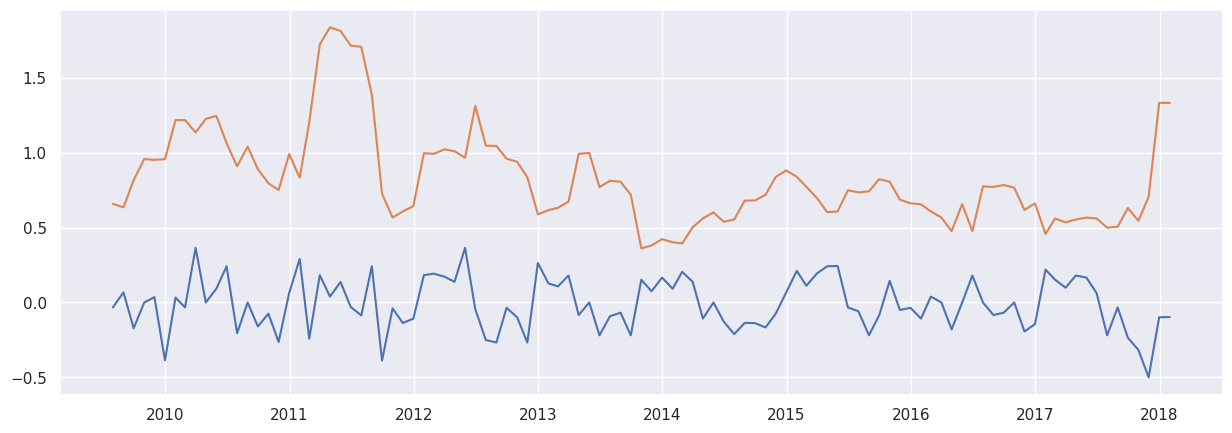

In [33]:
df_marsa_sqrt = np.sqrt(df_marsa)
df_marsa_dif_sqrt = df_marsa_sqrt.diff()


rolstd_dif_sqrt = df_marsa_dif_sqrt.rolling(window=6).mean()
rolmean_dif_sqrt = df_marsa_dif_sqrt.rolling(window=6).std()

plt.figure(figsize=(15,5))
plt.plot(rolstd_dif_sqrt)
plt.plot(rolmean_dif_sqrt)

### Dickey-Fuller Test

In [34]:
# Maxlag value depends on the number of observations
adfuller(df_training[0])
df_pvalue = adfuller(df_training[0])[1]
df_pvalue
adfuller(df_training[0])

(-5.405499608346754,
 3.2982686866716945e-06,
 7,
 88,
 {'1%': -3.506944401824286,
  '5%': -2.894989819214876,
  '10%': -2.584614550619835},
 421.1602241737998)

### Series Decomposition

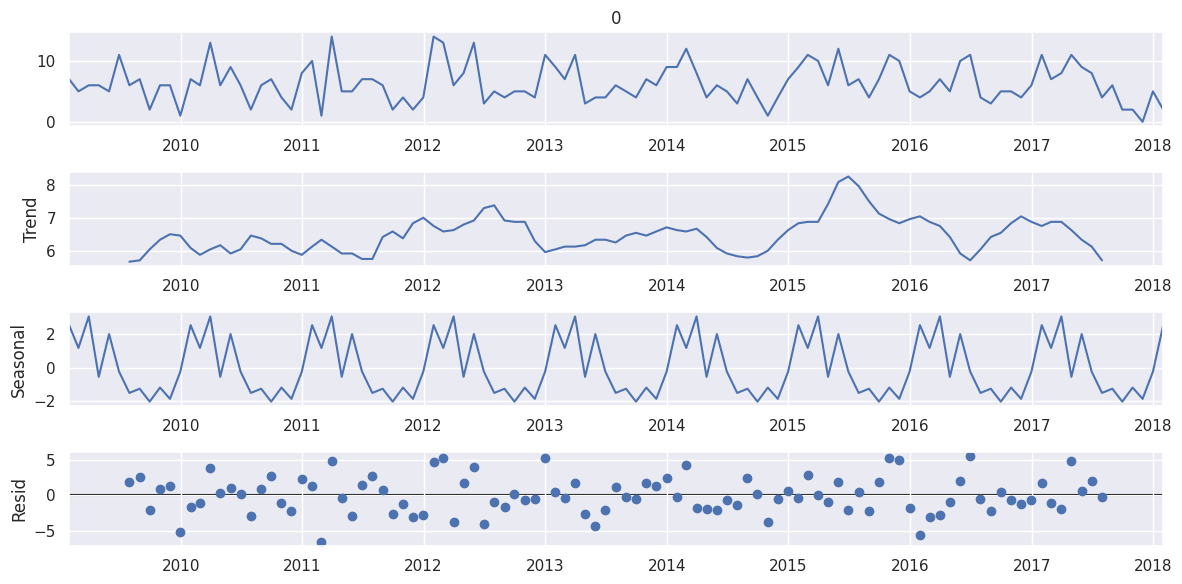

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_marsa[0], model='additive', period=12)
r = result.plot()

### ACF & PACF

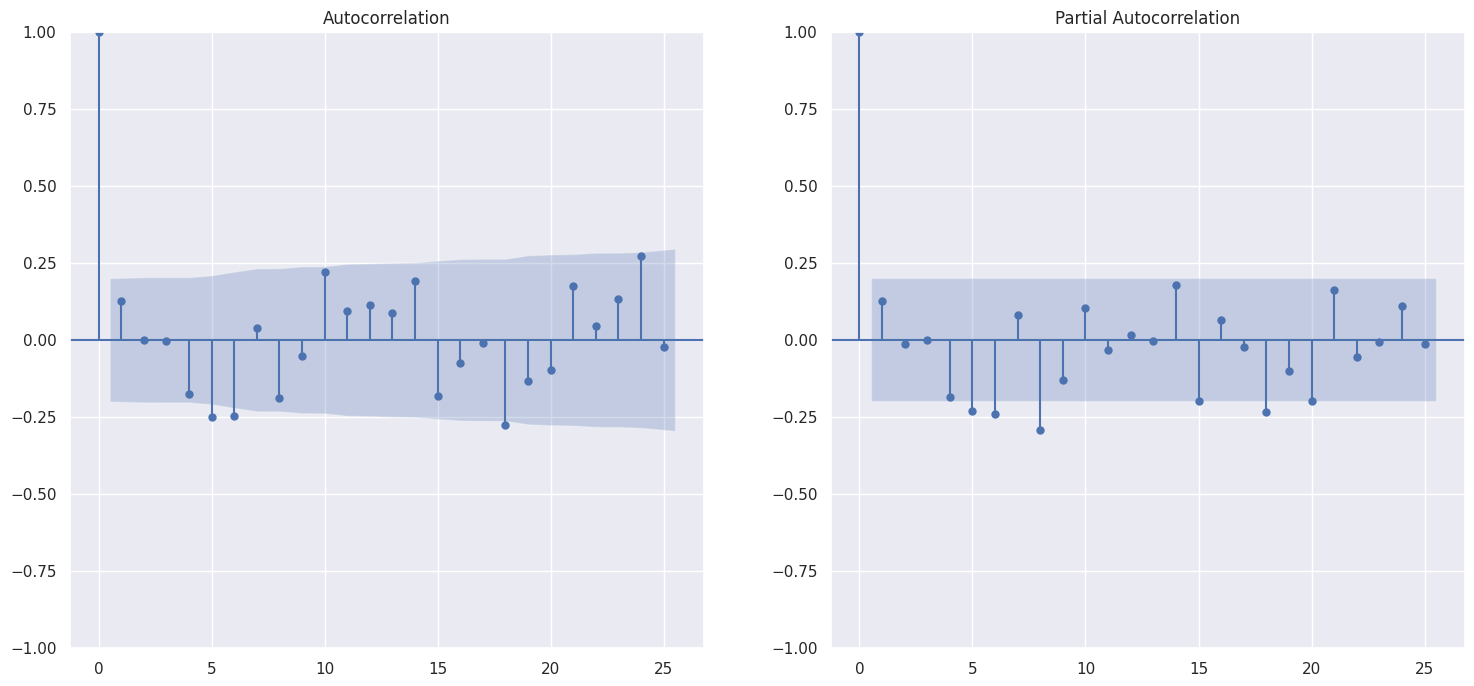

In [37]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plot_acf(df_training, ax=plt.gca(),lags=25)
plt.subplot(122)
plot_pacf(df_training, ax=plt.gca(), lags=25)
plt.show()

### Differenced Series ACF & PACF (d = 1)

In [38]:
df_diff = np.diff(df_training[0])

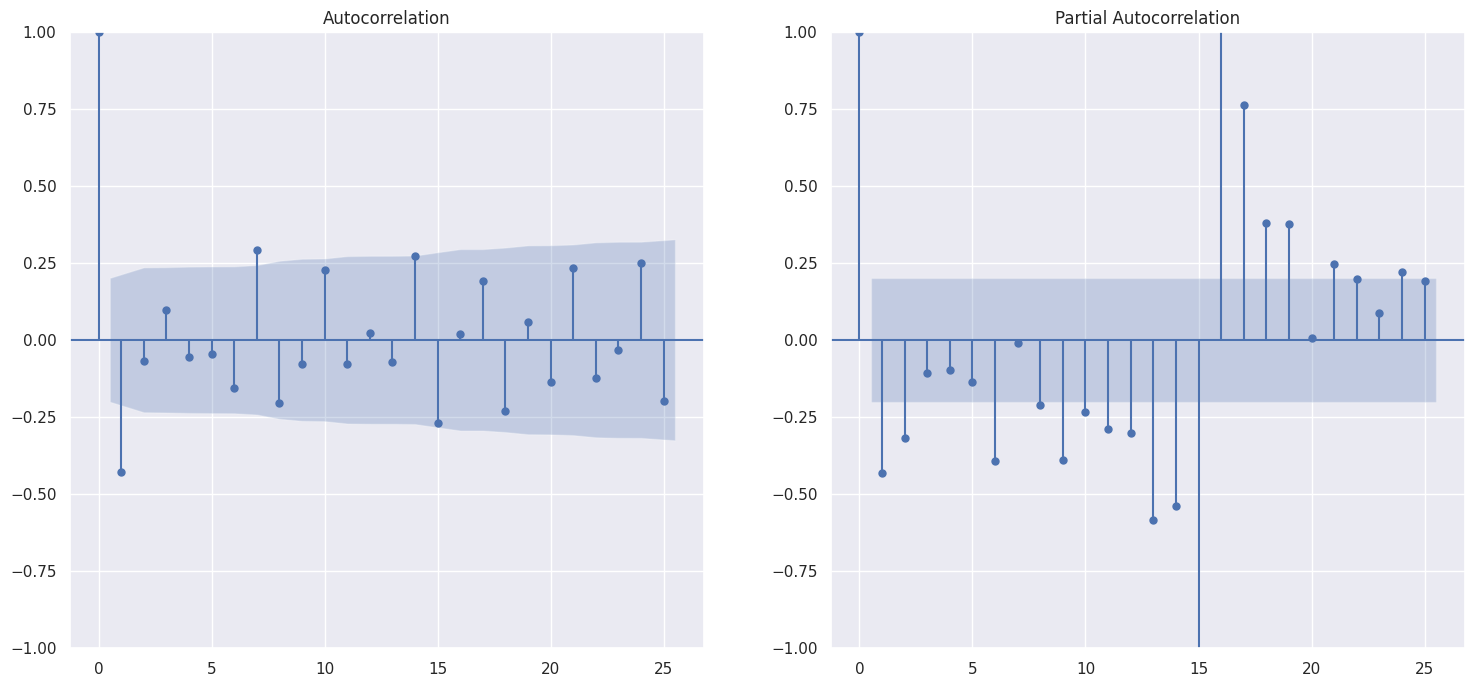

In [39]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plot_acf(df_diff, ax=plt.gca(),lags=25)
plt.subplot(122)
plot_pacf(df_diff, ax=plt.gca(), lags=25)
plt.show()

### Naive

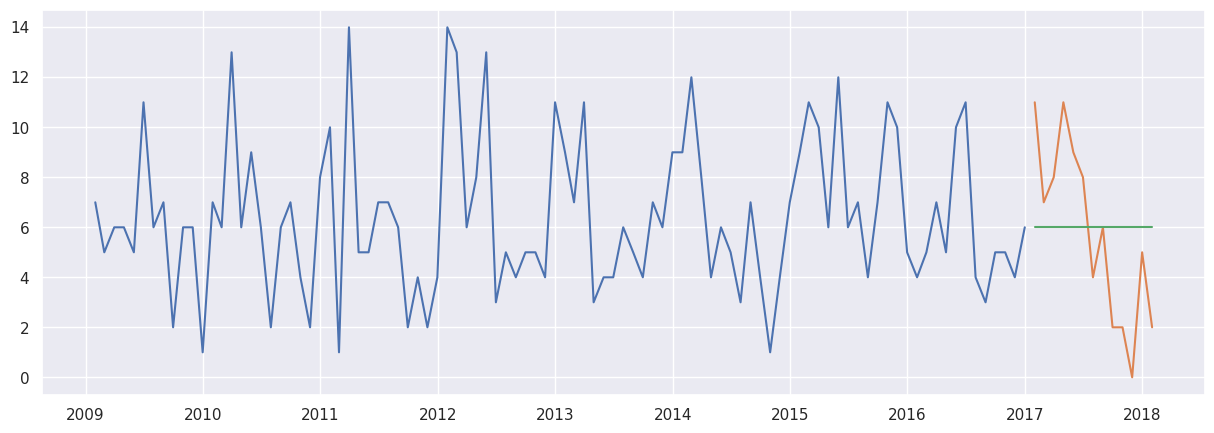

In [40]:
naive_test = np.full((1,len(df_test[0])), df_training[0][-1])
df_test['Naive'] = naive_test[0]

naive_rmse = get_rmse(df_test[0], df_test['Naive'])

plt.figure(figsize=(15,5))
plt.plot(df_training)
plt.plot(df_test[0])
plt.plot(df_test['Naive'])

In [41]:
naive_rmse

3.4751867686389284

### Simple Average

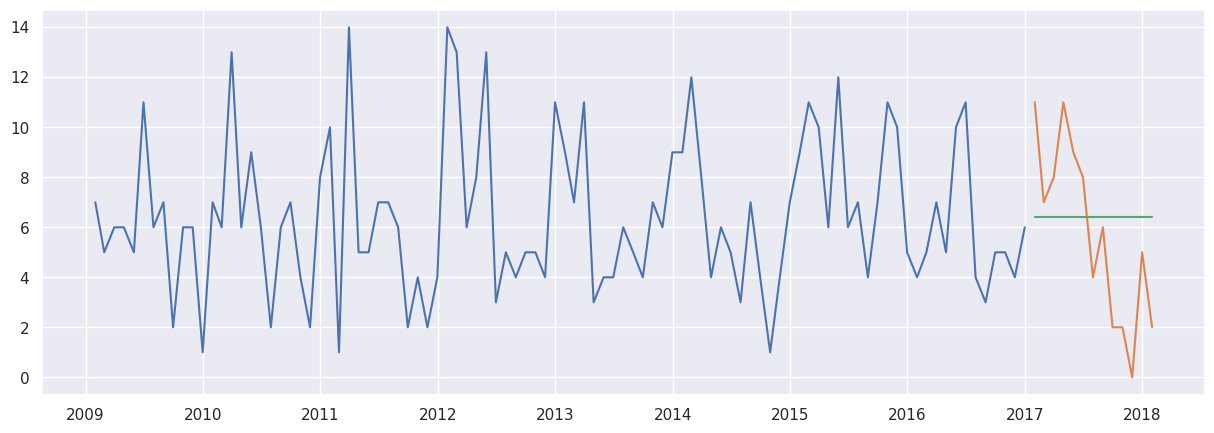

In [42]:
sa_test = np.full((1,len(df_test[0])), (df_training[0]).mean())
df_test['SimpleAverage'] = sa_test[0]

sa_rmse = get_rmse(df_test[0], df_test['SimpleAverage'])

plt.figure(figsize=(15,5))
plt.plot(df_training)
plt.plot(df_test[0])
plt.plot(df_test['SimpleAverage'])

In [43]:
sa_rmse

3.523676973332426

In [44]:
if naive_rmse < sa_rmse:
    rmse_val = naive_rmse
else:
    rmse_val = sa_rmse

### Holt-Winters

In [45]:
from statsmodels.tsa.api import ExponentialSmoothing

holt_grid = []
lst = ['mul', 'add']
   
for i in range(2, 13):
    for t in lst:
        for s in lst:
            fit1 = ExponentialSmoothing(df_training[0] ,seasonal_periods=i, trend=t, seasonal=s).fit()
            fc = fit1.forecast(len(df_test[0]))
            rmse = get_rmse(df_test[0], fc)
            holt_grid.append([[i, t, s], fit1.bic, fit1.aic, rmse])

In [46]:
holt_grid.sort(key=lambda x: x[3])
df_holtgrid = pd.DataFrame(holt_grid)
df_holtgrid = df_holtgrid[df_holtgrid[1] != np.inf]
df_holtgrid = df_holtgrid[pd.notnull(df_holtgrid[1])]
df_holtgrid = df_holtgrid[df_holtgrid[3] < rmse_val]

In [ ]:
save_to_pickle(df_holtgrid, 'dataframes/MARSA_holtwinters.pkl')

In [ ]:
df_holtgrid = load_from_pickle('dataframes/MARSA_holtwinters.pkl')
df_holtgrid.columns = ['Model', 'BIC', 'AIC', 'RMSE']
df_holtgrid

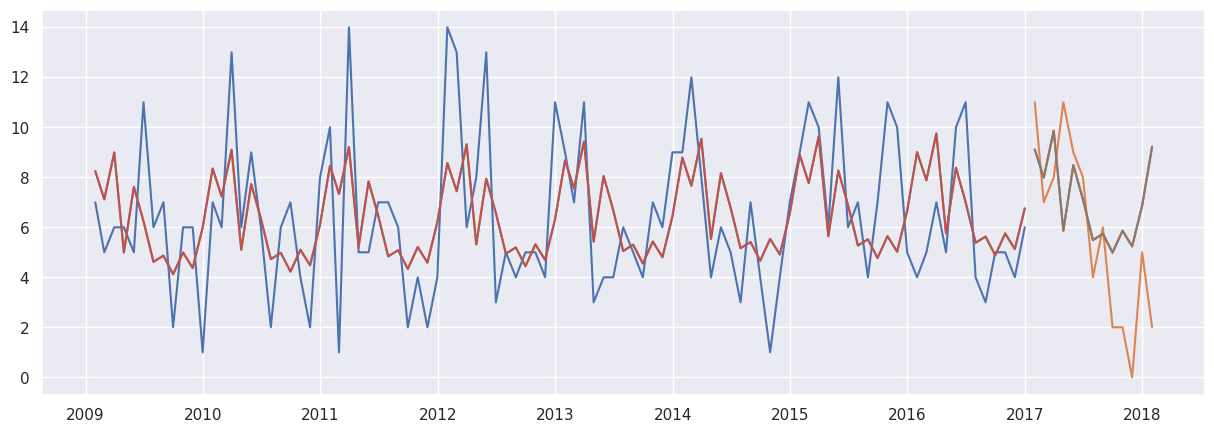

In [47]:
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(df_training[0], seasonal_periods=12, trend='mul', seasonal='add').fit()
fc1 = fit1.forecast(len(df_test[0]))

fit2 = ExponentialSmoothing(df_training[0], seasonal_periods=12, trend='add', seasonal='add').fit()
fc2 = fit2.forecast(len(df_test[0]))

plt.figure(figsize=(15,5))
plt.plot(df_training)
plt.plot(df_test[0])
plt.plot(fit1.fittedvalues)
plt.plot(fit2.fittedvalues)
plt.plot(fc1)
plt.plot(fc2)

### ARIMA

### Filtered by RMSE

In [ ]:
ma_rmse = df_grid[df_grid['RMSE'] < df_holtgrid.values[0][3]]
ma_rmse

### Ljung Box Filter

In [ ]:
fits = []
for i in ma_rmse['Model']:
    mod = SARIMAX(df_training[0], order=(int(i[0]), int(i[1]), int(i[2])), seasonal_order=(int(i[3]), int(i[4]),
                                                                                           int(i[5]), int(i[6])), 
                      enforce_stationarity=False, enforce_invertibility=False)
    fit = mod.fit()
    fits.append(fit)

In [ ]:
pvalue = []
for i in fits:
    try:
        a = i.summary()
        tb = a.tables[2]
        b = tb[1]
        pvalue.append(float(b.data[1]))
    except:
        pvalue.append(float(0.00))
        
ma_rmse['LjungBox'] = pvalue

In [ ]:
ma_rmse['Fit'] = fits
ma_ljungbox = ma_rmse[ma_rmse['LjungBox'] > 0.05]
ma_ljungbox

### Invertibility and Stationarity

In [ ]:
def test_invertibility_stationarity(fit):
    ma_roots = []
    ar_roots = []
    is_statio = True
    is_invert = True
    for ma in fit.maroots:
        ma_roots.append(np.sqrt(ma.real**2 + ma.imag**2))
    for ar in fit.arroots:
        ar_roots.append(np.sqrt(ar.real**2 + ar.imag**2))
    return not len([*filter(lambda x: x < 0.99, ma_roots)]) > 0, not len([*filter(lambda x: x < 0.99, ar_roots)]) > 0

def test_invertibility_abs(fit):
    ma_roots = []
    is_statio = True
    for ma in fit.maroots:
        ma_roots.append(np.abs(ma.real) + np.abs(ma.imag)) 
    return not len([*filter(lambda x: x < 0.99, ma_roots)]) > 0

def test_invertibility_stationarity_final(fit):
    is_statio = 1
    is_invert = 1
    for ma in fit.maroots:
        if np.abs(ma.real) < 0.99 and np.abs(ma.imag) < 0.99:
            is_invert = 0
            break
    for ar in fit.arroots:
        if np.abs(ar.real) < 0.99 and np.abs(ar.imag) < 0.99:
            is_statio = 0
            break
    return is_statio, is_invert

In [ ]:
invert_ = []
statio_ = []

for i in ma_ljungbox['Fit']:
    invert_.append(test_invertibility_stationarity(i))
    
linvert = [x[0] for x in invert_]
lstatio = [x[1] for x in invert_]

ma_invert = ma_ljungbox
ma_invert['Invertibility'] = linvert
ma_invert['Stationarity'] = lstatio

In [ ]:
invertibility_models = ma_invert[ma_invert['Invertibility'] == True]
invertibility_models['Fit'][28279].summary()
invert_statio_models = invertibility_models[invertibility_models['Stationarity'] == True]
invert_statio_models.hist(figsize=(10,8))

### Parsimony Filter

In [ ]:
models = invert_statio_models.drop(labels=['Invertibility', 'Stationarity', 'Fit', 'LjungBox'], axis=1)

In [ ]:
models.hist(figsize=(10,8))

In [ ]:
sum_models = []
for i in models['Model']:
    sum_models.append(sum(i[:len(i)-1]))
    
models['Parsimony'] = sum_models
ma_parsimony = models[models['Parsimony'] <= 8]

In [ ]:
ma_parsimony

In [ ]:
ma_parsimony.hist(figsize=(10,8))

### Complexity filter by AIC

In [ ]:
ma_par_aic = ma_parsimony[ma_parsimony['AIC'] < 450]
ma_par_aic = ma_par_aic.sort_values('RMSE')
ma_par_aic

In [ ]:
ma_par_aic.hist('AIC')

In [ ]:
ma_par_aic.hist('RMSE')

In [ ]:
ma_par_aic_rmse = ma_par_aic[ma_par_aic['RMSE'] <= 2.8]
ma_par_aic_rmse

df_training.hist()
np.std(df_training)

In [ ]:
ma_par_aic_rmse63 = ma_par_aic[ma_par_aic['RMSE3'] < ma_par_aic['RMSE6']]
ma_par_aic_rmsefinal = ma_par_aic_rmse63[ma_par_aic_rmse63['RMSE6'] < ma_par_aic_rmse63['RMSE']]
ma_par_aic_rmsefinal

In [ ]:
ma_orderedby_rmse = ma_par_aic.sort_values('RMSE')
ma_orderedby_rmse[:5]

In [ ]:
ma_orderedby_rmse6 = ma_par_aic.sort_values('RMSE6')
ma_orderedby_rmse6[:5]

In [ ]:
ma_orderedby_rmse3 = ma_par_aic.sort_values('RMSE3')
ma_orderedby_rmse3[:5]

In [ ]:
#[2, 0, 3, 2, 0, 1, 9]
#[3, 0, 0, 3, 1, 1, 10]

mod = SARIMAX(df_training[0], order=(4, 0, 1), seasonal_order=(1, 0, 2, 7), 
                      enforce_stationarity=False, enforce_invertibility=False)
fit = mod.fit()

training = go.Scatter(
                x = df_training.index,
                y=df_training.values,
                name = "Training",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

fitted = go.Scatter(
                x = df_training.index,
                y=fit.fittedvalues,
                name = "Fitted Values",
                line = dict(color = 'red'),
                opacity = 0.8)

forecast = go.Scatter(
                x = df_test.index,
                y=fit.predict(start = 96, end = len(df_marsa)-1),
                name = "Forecast",
                line = dict(color = 'blue'),
                opacity = 0.8)

test = go.Scatter(
                x = df_test.index,
                y= df_test[0].values,
                name = "Test",
                line = dict(color = 'green'),
                opacity = 0.8)

data = [training, fitted, forecast, test]

fig = dict(data=data)
py.iplot(fig, filename = "ARIMA")

In [ ]:
diagn = fit.plot_diagnostics(figsize=(16,12))

In [ ]:
import scipy.stats as stats
import pylab
prob_plot = stats.probplot(fit.resid, dist="norm",plot=pylab)

In [ ]:
acf_residuals = plot_acf(fit.resid, lags=25)

In [ ]:
fit.summary()

In [ ]:
listmodelos = []
listmodelostexto = []

for i in ma_orderedby_rmse3['Model']:
    mod = SARIMAX(df_training[0], order=(int(i[0]), int(i[1]), int(i[2])), 
                  seasonal_order=(int(i[3]), int(i[4]), int(i[5]), int(i[6])), 
                      enforce_stationarity=False, enforce_invertibility=False)
    fit = mod.fit()
    listmodelos.append(fit)
    listmodelostexto.append(i)

training = go.Scatter(
                x = df_training.index,
                y=df_training.values,
                name = "Training",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

forecast1 = go.Scatter(
                x = df_test.index,
                y=listmodelos[0].predict(start = 96, end = len(df_marsa)-1),
                name = str(listmodelostexto[0]),
                line = dict(color = 'orange'),
                opacity = 0.8)

forecast2 = go.Scatter(
                x = df_test.index,
                y=listmodelos[1].predict(start = 96, end = len(df_marsa)-1),
                name = str(listmodelostexto[1]),
                line = dict(color = 'green'),
                opacity = 0.8)

forecast3 = go.Scatter(
                x = df_test.index,
                y=listmodelos[2].predict(start = 96, end = len(df_marsa)-1),
                name = str(listmodelostexto[2]),
                line = dict(color = 'magenta'),
                opacity = 0.8)

forecast4 = go.Scatter(
                x = df_test.index,
                y=listmodelos[3].predict(start = 96, end = len(df_marsa)-1),
                name = str(listmodelostexto[3]),
                line = dict(color = 'red'),
                opacity = 0.8)

forecast5 = go.Scatter(
                x = df_test.index,
                y=listmodelos[4].predict(start = 96, end = len(df_marsa)-1),
                name = str(listmodelostexto[4]),
                line = dict(color = 'darkgrey'),
                opacity = 0.8)

test = go.Scatter(
                x = df_test.index,
                y= df_test[0].values,
                name = "Test",
                line = dict(color = 'blue'),
                opacity = 1)

data = [training, forecast1, forecast2, forecast3, forecast4, forecast5, test]

fig = dict(data=data)
py.iplot(fig, filename = "ARIMA")